In [34]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [35]:
%cd /content/drive/MyDrive/Summer2025/IoT_Sensors_Prediction_and_Classification-main/IoT_Sensors_Prediction_and_Classification-main/script

/content/drive/MyDrive/Summer2025/IoT_Sensors_Prediction_and_Classification-main/IoT_Sensors_Prediction_and_Classification-main/script


In [36]:
import torch
import json
import torch.nn as nn
import numpy as np
from tqdm.auto import tqdm
from torch.utils.data import DataLoader
from utils import learning_curve_pred
# from model import CNNLSTM, CNNGRU
from load_data import pred_data_train


In [37]:
with open("../config.json", "r") as file:
    config = json.load(file)


In [38]:
import torch.nn as nn
import torch

class CNNMLP(nn.Module):
  def __init__(self, input_channel=1,output_channel=3,
               num_cnn_layers=1,window_size=1, num_output_units=5):
    super(CNNMLP, self).__init__()
    self.num_cnn_layers = num_cnn_layers
    self.window_size = window_size

    self.layers = self.CreateLayer(input_channel,output_channel, num_output_units)

  def forward(self, x):
    out = self.layers(x)

    return out

  def CreateLayer(self, input_channel,output_channel, num_output_units):
    layer = []
    for i in range(self.num_cnn_layers):
      layer.append(nn.Conv1d(input_channel, output_channel, kernel_size=1, padding=0, bias=False))
      layer.append(nn.BatchNorm1d(output_channel))
      layer.append(nn.ReLU())
      input_channel = output_channel
    layer.append(nn.Flatten())
    layer.append(nn.Linear(output_channel*self.window_size, num_output_units))

    return nn.Sequential(*layer)


class CNNLSTM(nn.Module):
  def __init__(self,input_size, lstm_hidden_units, cnn_output_channel,
               num_mote_ids, lstm_hidden_layer=1, embed_dim=2):
    super(CNNLSTM,self).__init__()
    self.lstm_input_size = cnn_output_channel + embed_dim
    self.lstm_hidden_units = lstm_hidden_units
    self.lstm_hidden_layer = lstm_hidden_layer
    self.mote_embed = nn.Embedding(num_mote_ids, embed_dim)

    self.cnn = nn.Conv1d(in_channels=input_size, out_channels=cnn_output_channel,
                         kernel_size=3, padding=1, stride=1)
    self.lstm = nn.LSTM(input_size=self.lstm_input_size, hidden_size=lstm_hidden_units,
                        num_layers=lstm_hidden_layer, batch_first=True)

    self.fc = nn.Linear(lstm_hidden_units, 1)

  def forward(self,x_num, x_cat):
    batch_size = x_num.shape[0]

    x_num = x_num.permute(0,2,1)
    x_num = self.cnn(x_num)
    x_num = x_num.permute(0,2,1)

    mote_id_emb = self.mote_embed(x_cat[:, :, 0])

    combined_input = torch.cat((x_num, mote_id_emb), dim=2)

    h0, c0 = self.initial_hidden(batch_size)
    h0, c0 = h0.to(x_num.device), c0.to(x_num.device)

    out, (hidden, cell) = self.lstm(combined_input, (h0, c0))
    out = self.fc(out[:,-1, :])

    return out

  def initial_hidden(self, batch_size):
    hidden = torch.zeros(self.lstm_hidden_layer, batch_size, self.lstm_hidden_units)
    cell = torch.zeros(self.lstm_hidden_layer, batch_size, self.lstm_hidden_units)
    return hidden, cell



class CNNGRU(nn.Module):
  def __init__(self,input_size, gru_hidden_units, cnn_output_channel,
               num_mote_ids, gru_hidden_layer=1, embed_dim=2):
    super(CNNGRU,self).__init__()
    self.gru_input_size = cnn_output_channel + embed_dim
    self.gru_hidden_units = gru_hidden_units
    self.gru_hidden_layer = gru_hidden_layer
    self.mote_embed = nn.Embedding(num_mote_ids, embed_dim)

    self.cnn = nn.Conv1d(in_channels=input_size, out_channels=cnn_output_channel,
                         kernel_size=3, padding=1, stride=1)
    self.gru = nn.GRU(input_size=self.gru_input_size, hidden_size=gru_hidden_units,
                        num_layers=gru_hidden_layer, batch_first=True)

    self.fc = nn.Linear(gru_hidden_units, 1)

  def forward(self,x_num, x_cat):
    batch_size = x_num.shape[0]

    x_num = x_num.permute(0,2,1)
    x_num = self.cnn(x_num)
    x_num = x_num.permute(0,2,1)

    mote_id_emb = self.mote_embed(x_cat[:, :, 0])

    combined_input = torch.cat((x_num, mote_id_emb), dim=2)
    h0 = self.initial_hidden(batch_size)
    h0= h0.to(x_num.device)

    out, hidden = self.gru(combined_input, h0)
    out = self.fc(out[:,-1, :])

    return out

  def initial_hidden(self, batch_size):
    hidden = torch.zeros(self.gru_hidden_layer, batch_size, self.gru_hidden_units)
    return hidden




In [39]:
def train(model, train_dl, optimizer, loss_fnc, mae, device):
    model.train()
    total_loss = 0
    total_mae = 0
    for X_num, X_cat, y in train_dl:
        optimizer.zero_grad()
        X_num, X_cat, y = X_num.to(device), X_cat.to(device), y.to(device)
        out = model(X_num, X_cat)
        loss = loss_fnc(out.view(-1), y.view(-1))
        cur_mae = mae(out.view(-1), y.view(-1))
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_mae += cur_mae.item()

    avg_mse = total_loss/ len(train_dl)
    avg_rmse = avg_mse ** 0.5
    avg_mae = total_mae / len(train_dl)

    return avg_mse, avg_rmse, avg_mae

def valid(model, valid_dl, loss_fnc, mae, device):
    model.eval()
    total_loss = 0
    total_mae = 0
    with torch.no_grad():
        for X_num, X_cat, y in valid_dl:
            X_num, X_cat, y = X_num.to(device), X_cat.to(device), y.to(device)
            out = model(X_num, X_cat)
            loss = loss_fnc(out.view(-1), y.view(-1))
            cur_mae = mae(out.view(-1), y.view(-1))

            total_loss += loss.item()
            total_mae += cur_mae.item()

    avg_mse = total_loss/ len(valid_dl)
    avg_rmse = avg_mse ** 0.5
    avg_mae = total_mae / len(valid_dl)

    return avg_mse, avg_rmse, avg_mae


def train_epochs(epochs, train_dl, valid_dl,model, optimizer,loss_fnc, mae, device):

    history = {
        "train_mse": [],
        "valid_mse": [],
        "train_rmse": [],
        "valid_rmse": [],
        "train_mae": [],
        "valid_mae": []
    }

    for epoch  in tqdm(range(1, epochs+1)):
        train_mse, train_rmse, train_mae = train(model, train_dl, optimizer, loss_fnc,mae,  device)
        val_mse, val_rmse, val_mae = valid(model, valid_dl,loss_fnc, mae, device)

        print(f"Epoch: {epoch} |", f"Train MSE: {train_mse:.4f} |", f"Valid MSE: {val_mse:.4f} |",
              f"Train RMSE: {train_rmse:.4f} |", f"Valid RMSE: {val_rmse:.4f} |",
              f"Train MAE: {train_mae:.4f} |", f"Valid MAE: {val_mae:.4f} |")

        history["train_mse"].append(train_mse)
        history["valid_mse"].append(val_mse)
        history["train_rmse"].append(train_rmse)
        history["valid_rmse"].append(val_rmse)
        history["train_mae"].append(train_mae)
        history["valid_mae"].append(val_mae)

    return history


In [40]:

torch.manual_seed(42)
train_data, valid_data = pred_data_train()

batch_size = 64
train_dl = DataLoader(train_data, batch_size=batch_size, shuffle=False)
valid_dl = DataLoader(valid_data, batch_size=batch_size, shuffle=False)

In [41]:
for item in train_dl:
    print(item[0].shape, item[1].shape, item[2].shape)
    print(item[0][0], item[1][0], item[2][0])
    break

torch.Size([64, 8, 1]) torch.Size([64, 8, 1]) torch.Size([64])
tensor([[-0.7921],
        [-0.7922],
        [-0.7922],
        [-0.7922],
        [-0.7922],
        [-0.7922],
        [-0.7923],
        [-0.7923]]) tensor([[0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0]]) tensor(-0.7923)


In [42]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
lr = 1e-4
epochs = 4
loss_fnc = nn.MSELoss()
mae = nn.L1Loss()

cuda


In [43]:
    #  Train CNN_LSTM
lstm_model = CNNLSTM(input_size=1, lstm_hidden_units=8, cnn_output_channel=3,
            num_mote_ids=10, embed_dim=2).to(device)
# lstm_model = CNNGRU(input_size=1, gru_hidden_units=8, cnn_output_channel=3,
#             num_mote_ids=10, embed_dim=2).to(device)
lstm_model


CNNLSTM(
  (mote_embed): Embedding(10, 2)
  (cnn): Conv1d(1, 3, kernel_size=(3,), stride=(1,), padding=(1,))
  (lstm): LSTM(5, 8, batch_first=True)
  (fc): Linear(in_features=8, out_features=1, bias=True)
)

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 1 | Train MSE: 0.0182 | Valid MSE: 0.0091 | Train RMSE: 0.1348 | Valid RMSE: 0.0954 | Train MAE: 0.0491 | Valid MAE: 0.0888 |
Epoch: 2 | Train MSE: 0.0016 | Valid MSE: 0.0017 | Train RMSE: 0.0399 | Valid RMSE: 0.0418 | Train MAE: 0.0129 | Valid MAE: 0.0320 |
Epoch: 3 | Train MSE: 0.0009 | Valid MSE: 0.0007 | Train RMSE: 0.0300 | Valid RMSE: 0.0267 | Train MAE: 0.0090 | Valid MAE: 0.0085 |
Epoch: 4 | Train MSE: 0.0007 | Valid MSE: 0.0008 | Train RMSE: 0.0273 | Valid RMSE: 0.0284 | Train MAE: 0.0065 | Valid MAE: 0.0158 |


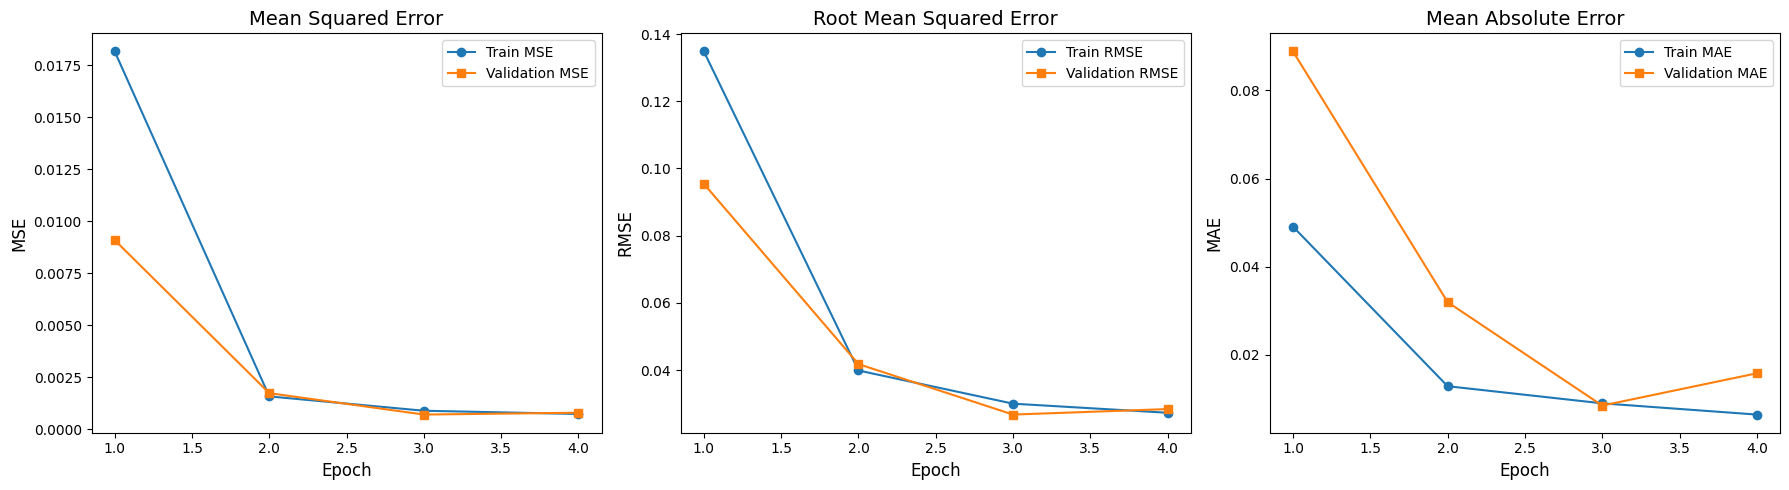

In [44]:
lstm_optimizer = torch.optim.Adam(lstm_model.parameters(), lr)

history = train_epochs(epochs, train_dl, valid_dl, lstm_model,lstm_optimizer, loss_fnc, mae, device)
learning_curve_pred(history, config["cnnlstm_lrn_plot_path"])


In [45]:
torch.save(lstm_model.state_dict(), "../cnnlstm_model.pt")

# Task
Load the saved CNN-LSTM model, modify it to extract features before the final layer, generate features for training and validation data using the modified model, and then train and evaluate an XGBoost model using these features.

## Load the saved cnn-lstm model

### Subtask:
Load the state dictionary of the trained CNN-LSTM model.


**Reasoning**:
Instantiate a new CNNLSTM model and load the saved state dictionary.



In [46]:
new_lstm_model = CNNLSTM(input_size=1, lstm_hidden_units=8, cnn_output_channel=3,
                        num_mote_ids=10, embed_dim=2).to(device)
new_lstm_model.load_state_dict(torch.load("../cnnlstm_model.pt"))

<All keys matched successfully>

## Modify the cnn-lstm model for feature extraction

### Subtask:
Modify the existing CNN-LSTM model to output the features before the final linear layer.


**Reasoning**:
Modify the CNN-LSTM model to output the features before the final linear layer.



In [60]:
class CNNLSTMFeatureExtractor(nn.Module):
    def __init__(self, original_model):
        super(CNNLSTMFeatureExtractor, self).__init__()
        self.cnn = original_model.cnn
        self.mote_embed = original_model.mote_embed
        self.lstm = original_model.lstm
        self.lstm_hidden_layer = original_model.lstm_hidden_layer
        self.lstm_hidden_units = original_model.lstm_hidden_units

    def forward(self, x_num, x_cat):
        batch_size = x_num.shape[0]

        x_num = x_num.permute(0, 2, 1)
        x_num = self.cnn(x_num)
        x_num = x_num.permute(0, 2, 1)

        mote_id_emb = self.mote_embed(x_cat[:, :, 0])

        combined_input = torch.cat((x_num, mote_id_emb), dim=2)
        return combined_input.reshape(batch_size, -1)
        h0, c0 = self.initial_hidden(batch_size)
        h0, c0 = h0.to(x_num.device), c0.to(x_num.device)

        out, (hidden, cell) = self.lstm(combined_input, (h0, c0))
        return out[:, -1, :] # Return the output of the last time step before the linear layer

    def initial_hidden(self, batch_size):
        hidden = torch.zeros(self.lstm_hidden_layer, batch_size, self.lstm_hidden_units)
        cell = torch.zeros(self.lstm_hidden_layer, batch_size, self.lstm_hidden_units)
        return hidden, cell

feature_extractor = CNNLSTMFeatureExtractor(new_lstm_model).to(device)
feature_extractor.eval()

CNNLSTMFeatureExtractor(
  (cnn): Conv1d(1, 3, kernel_size=(3,), stride=(1,), padding=(1,))
  (mote_embed): Embedding(10, 2)
  (lstm): LSTM(5, 8, batch_first=True)
)

## Generate features using the modified model

### Subtask:
Pass the training and validation data through the modified model to obtain the features.


**Reasoning**:
Initialize lists to store features and targets, then iterate through the training and validation DataLoaders to extract features using the modified model and collect the corresponding target variables.



In [63]:
import numpy as np

train_features = []
train_targets = []
valid_features = []
valid_targets = []

with torch.no_grad():
    for X_num, X_cat, y in train_dl:
        X_num, X_cat = X_num.to(device), X_cat.to(device)
        features = feature_extractor(X_num, X_cat)
        train_features.append(features.cpu().numpy())
        train_targets.append(y.cpu().numpy())

    for X_num, X_cat, y in valid_dl:
        X_num, X_cat = X_num.to(device), X_cat.to(device)
        features = feature_extractor(X_num, X_cat)
        valid_features.append(features.cpu().numpy())
        valid_targets.append(y.cpu().numpy())

train_features = np.concatenate(train_features, axis=0)
train_targets = np.concatenate(train_targets, axis=0)
valid_features = np.concatenate(valid_features, axis=0)
valid_targets = np.concatenate(valid_targets, axis=0)

print("Training features shape:", train_features.shape)
print("Training targets shape:", train_targets.shape)
print("Validation features shape:", valid_features.shape)
print("Validation targets shape:", valid_targets.shape)

Training features shape: (806336, 40)
Training targets shape: (806336,)
Validation features shape: (100792, 40)
Validation targets shape: (100792,)


In [62]:
features.shape


torch.Size([56, 40])

## Train an xgboost model

### Subtask:
Use the generated features and the target variable to train an XGBoost model.


**Reasoning**:
Import the necessary library for XGBoost and train the XGBoost model using the generated features and targets.



In [64]:
import xgboost as xgb

# Instantiate XGBRegressor
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)

# Train the model
xgb_model.fit(train_features, train_targets)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

## Evaluate the xgboost model

### Subtask:
Evaluate the performance of the trained XGBoost model.


**Reasoning**:
Evaluate the performance of the trained XGBoost model using MSE, RMSE, and MAE.



In [65]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Make predictions on the validation features
valid_predictions = xgb_model.predict(valid_features)

# Calculate metrics
mse = mean_squared_error(valid_targets, valid_predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(valid_targets, valid_predictions)

# Print the results
print(f"Validation MSE: {mse:.4f}")
print(f"Validation RMSE: {rmse:.4f}")
print(f"Validation MAE: {mae:.4f}")

Validation MSE: 0.0005
Validation RMSE: 0.0213
Validation MAE: 0.0033


## Summary:

### Data Analysis Key Findings

*   The original CNN-LSTM model was successfully loaded.
*   A feature extraction model was created by removing the final linear layer from the loaded CNN-LSTM model.
*   Features for both the training and validation datasets were generated using the modified feature extraction model.
*   An XGBoost regression model was trained using the extracted features and the corresponding target variables.

### Insights or Next Steps

*   The low error metrics (MSE, RMSE, MAE) on the validation set suggest that the features extracted by the modified CNN model are effective for training a predictive model like XGBoost.



# Task
Add LIME and SHAP explainability to the trained XGBoost model.

## Install necessary libraries

### Subtask:
Install the `lime` and `shap` libraries.


**Reasoning**:
The subtask is to install the `lime` and `shap` libraries. This can be done using pip in a code block.



In [66]:
%pip install lime shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 18.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=623feba971e80d2c9122f93b207ecb7ebd4be727d2f9918e6cd62da305e7906e
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


## Prepare data for lime

### Subtask:
Create a LIME explainer and a function to predict probabilities for the XGBoost model.


**Reasoning**:
Import the necessary library for LIME and define a prediction function for the XGBoost model, then instantiate the LIME explainer.



In [67]:
from lime.lime_tabular import LimeTabularExplainer

def xgb_predict(data):
    return xgb_model.predict(data)

explainer = LimeTabularExplainer(training_data=train_features,
                                 feature_names=[f'feature_{i}' for i in range(train_features.shape[1])],
                                 mode='regression')

## Generate lime explanations

### Subtask:
Generate explanations for a few instances in the validation set using the LIME explainer.


**Reasoning**:
Generate explanations for a few instances in the validation set using the LIME explainer.



In [68]:
num_explanations = 3
num_features_to_show = 10
explanations = []

for i in range(num_explanations):
    instance_to_explain = valid_features[i]
    explanation = explainer.explain_instance(data_row=instance_to_explain,
                                             predict_fn=xgb_predict,
                                             num_features=num_features_to_show)
    explanations.append(explanation)
    print(f"Explanation for instance {i+1}:")
    print(explanation.as_list())

Explanation for instance 1:
[('feature_36 <= -0.02', -0.05866197932629478), ('feature_32 <= -1.17', -0.027042232475934215), ('feature_21 <= -0.56', 0.01954343531740046), ('feature_16 <= -0.56', -0.0195010569967916), ('feature_17 <= -1.17', -0.015969173453096387), ('feature_22 <= -1.17', 0.015261683257891937), ('feature_2 <= -0.75', -0.014338209536818398), ('feature_5 > 0.59', 0.012541249121718957), ('feature_26 <= -0.56', -0.011687948763793265), ('feature_31 <= -0.56', -0.011315678916239419)]
Explanation for instance 2:
[('feature_36 <= -0.02', -0.05395946546765014), ('feature_32 <= -1.17', -0.020162991909071015), ('feature_17 <= -1.17', -0.018576657807657604), ('feature_26 <= -0.56', -0.017233455311503814), ('feature_31 <= -0.56', -0.016327104539750455), ('feature_2 <= -0.75', -0.01605554673291259), ('feature_16 <= -0.56', -0.014364834634880157), ('feature_20 > 0.59', -0.01235887319342071), ('feature_22 <= -1.17', 0.012150936845752056), ('feature_33 > 0.74', 0.01170070155321683)]
Expl

## Visualize lime explanations

### Subtask:
Visualize the generated LIME explanations for the selected instances.


**Reasoning**:
Iterate through the generated explanations and display each explanation as a matplotlib figure.



Explanation visualization for instance 1:


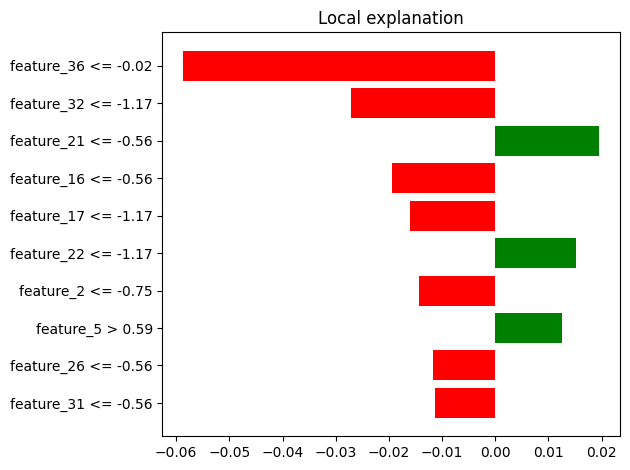

Explanation visualization for instance 2:


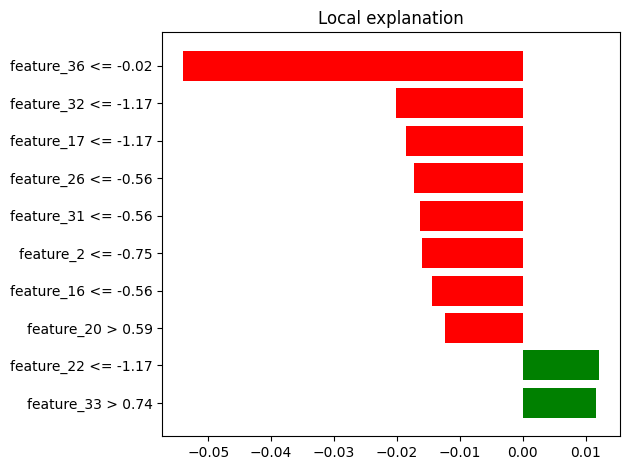

Explanation visualization for instance 3:


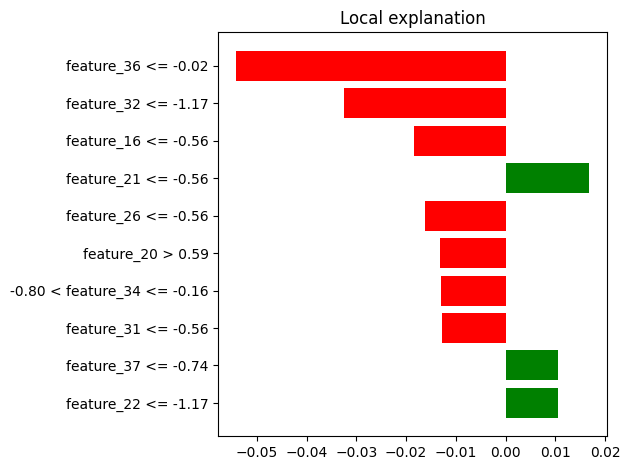

In [69]:
import matplotlib.pyplot as plt

for i, explanation in enumerate(explanations):
    print(f"Explanation visualization for instance {i+1}:")
    explanation.as_pyplot_figure()
    plt.tight_layout()
    plt.show()

## Prepare data for shap

### Subtask:
Create a SHAP explainer for the trained XGBoost model.


**Reasoning**:
Import the necessary classes for SHAP and create a TreeExplainer for the trained XGBoost model.



In [70]:
from shap import TreeExplainer

explainer_shap = TreeExplainer(xgb_model)

## Generate shap explanations

### Subtask:
Generate SHAP explanations for the validation set using the SHAP explainer.


**Reasoning**:
Use the SHAP explainer to compute the SHAP values for the validation features.



In [71]:
shap_values_valid = explainer_shap.shap_values(valid_features)

## Visualize shap explanations

### Subtask:
Visualize the generated SHAP explanations for the validation set.


**Reasoning**:
Generate SHAP summary and dependence plots for the validation set to visualize the feature importance and relationships.



Generating SHAP summary plot...


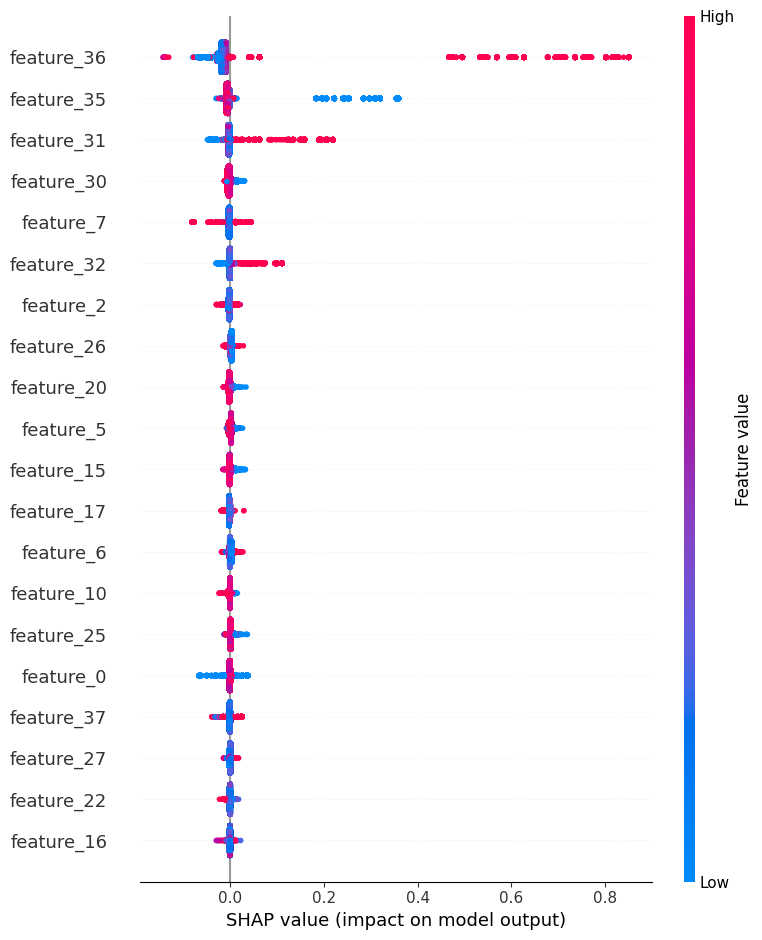

Generating SHAP dependence plots...


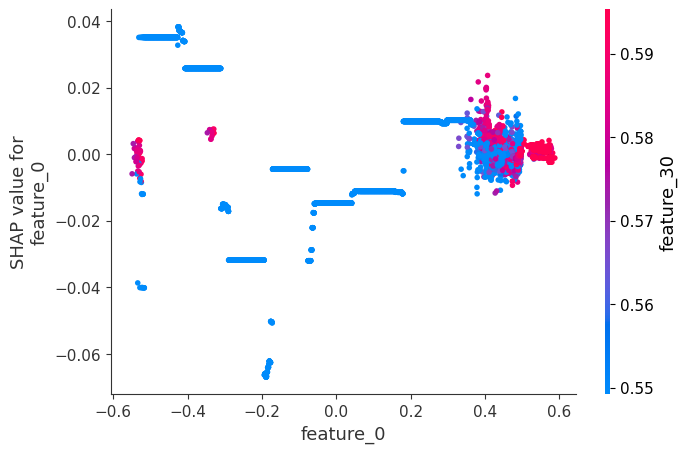

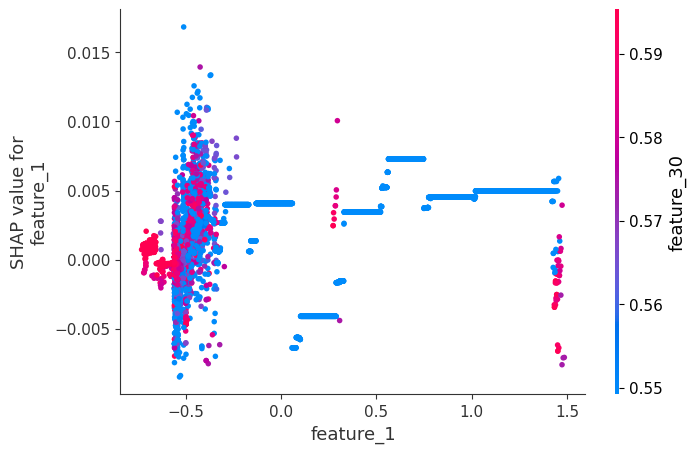

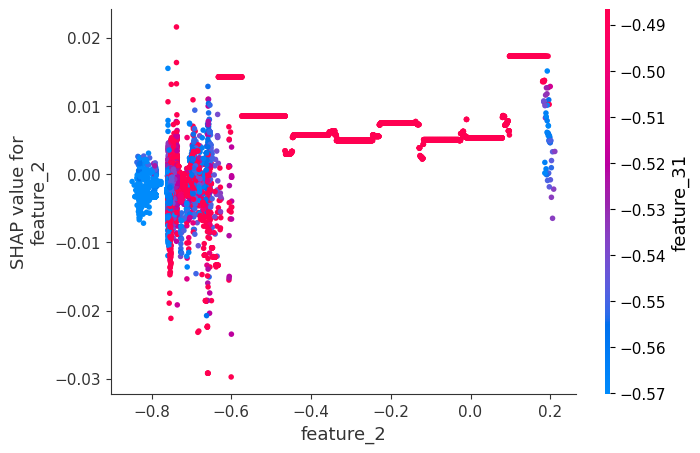

In [72]:
import matplotlib.pyplot as plt
import shap

# Generate a summary plot
print("Generating SHAP summary plot...")
shap.summary_plot(shap_values_valid, valid_features, feature_names=[f'feature_{i}' for i in range(valid_features.shape[1])])
plt.show()

# Generate dependence plots for a few selected features
print("Generating SHAP dependence plots...")
# Choose a few features based on the summary plot or domain knowledge
selected_features_indices = [0, 1, 2] # Example indices, replace with relevant feature indices

for feature_index in selected_features_indices:
    shap.dependence_plot(feature_index, shap_values_valid, valid_features, feature_names=[f'feature_{i}' for i in range(valid_features.shape[1])])
    plt.show()

## Interpret explanations

### Subtask:
Interpret the insights gained from the LIME and SHAP explanations.


## Summary:

### Data Analysis Key Findings

*   LIME explanations were successfully generated for individual instances, showing local feature importance.
*   SHAP explanations provided global feature importance insights through a summary plot and feature interactions through dependence plots.
*   Both LIME and SHAP were successfully applied to the trained XGBoost model to provide interpretability.

### Insights or Next Steps

*   Analyze the LIME and SHAP explanations further to identify specific patterns in how different features influence predictions and potentially identify areas for model improvement or feature engineering.
*   Consider using these interpretability techniques to communicate the model's decision-making process to stakeholders.
